In [392]:
############ Settings ############

# From https://aspe.hhs.gov/topics/poverty-economic-mobility/poverty-guidelines
poverty_line = 13590

# Salary per year that you'd be happy with
income_for_happy = 70000

# Weights
poverty_weight = 4
income_weight = 7
housing_weight = 4
lgbtq_weight = 6

# State Names
states = ["Delaware", "Maine", "Maryland", "Massachusetts", "New Hampshire", "New Jersey", "New York", "Pennsylvania", "Rhode Island", "Vermont", "Virginia"]

In [393]:
import pandas
import math

In [394]:
db_poverty = pandas.read_csv("ACSST5Y2020.S1701-2022-11-02T235828.csv")
db_income = pandas.read_csv("ACSST5Y2020.S1901-2022-11-03T011324.csv")
db_house = pandas.read_csv("ACSST1Y2021.S2507-2022-11-04T021940.csv")

In [395]:
# Set global values

# Calculate Income Weights
income_weights = []
ranges = [10000,14999,24999,34999,49999,74999,99999,149999,199999]

# From https://www.desmos.com/calculator/vpzyf979wi
v_bottom = income_for_happy - poverty_line
for val in ranges:
    v_top = val - poverty_line
    income_weights.append(v_top / v_bottom)

# Equaldex Score for each of the states
lgbtq_s = [78,82,81,86,83,82,82,73,84,86,67]

In [396]:
# Drop every row not needed
db_poverty = db_poverty[:-67]
db_income = db_income[1:10]

# Drop all columns that are not needed
db_poverty = db_poverty.filter(regex="(Percent below poverty level!!Estimate)")
db_income = db_income.filter(regex="(Nonfamily households!!Estimate)|(Label \(Grouping\))")

In [397]:
def change_column_names_poverty():
    global db_poverty
    old_names = list(db_poverty)
    new_names = list()
    for name in old_names:
        n_name = name.split("!!")[0]
        new_names.append(n_name)

    db_poverty.columns = new_names

def change_column_names_income():
    global db_income
    old_names = list(db_income)
    new_names = list()
    for name in old_names:
        n_name = name.split("!!")[0]
        new_names.append(n_name)

    db_income.columns = new_names

    db_income = db_income.rename(columns={"Label (Grouping)" : "% of Pop. (Nonfamily) Income"})

In [398]:
# Change Column Names
change_column_names_poverty()
change_column_names_income()

# Change Row Name
db_poverty = db_poverty.rename(index={0 : "% of Pop. Below Poverty Level"})
db_house = db_house.rename(index={10 : "m_house"})
db_house = db_house.rename(index={63 : "m_rent"})

In [399]:
# Get poverty values out of sheet
poverty_values = db_poverty.loc["% of Pop. Below Poverty Level", :].values.tolist()
for i in range(len(poverty_values)):
    poverty_values[i] = float(poverty_values[i][:-1])

In [400]:
# Calculate income values
# From https://www.desmos.com/calculator/vpzyf979wi
income_values = []
for column in db_income.columns[1:]:
    values = db_income[column].values.tolist()
    tmp_values = []
    for i in range(len(values)):
        value = float(values[i][:-1])
        tmp_values.append(value * income_weights[i])

    income_values.append(math.fsum(tmp_values))

In [401]:
# Get median house costs from data set
median_house_cost = db_house.loc["m_house", :].values.tolist()[1:]
for i in range(len(median_house_cost)):
    median_house_cost[i] = int(median_house_cost[i].replace(',', ''))

# Remove dups
median_house_cost = [*set(median_house_cost)]

In [402]:
# Calculate State Values
s_values = []

poverty_h = max(poverty_values)
income_h = max(income_values)
house_h = max(median_house_cost)
lgbt_h = max(lgbtq_s)

for i in range(len(states)):
    poverty = (poverty_values[i] / poverty_h) * poverty_weight
    income = (income_values[i] / income_h) * income_weight
    house = (median_house_cost[i] / house_h) * housing_weight
    lgbt = (lgbtq_s[i] / lgbt_h) * lgbtq_weight
    s_values.append(poverty + income + house + lgbt)

high = max(s_values)
for i in range(len(s_values)):
    s_values[i] = round(s_values[i] / high, 3)

In [403]:
# Create dict
result = dict(zip(states, s_values))

# Sort dict
result = {w: result[w] for w in sorted(result, key=result.get, reverse=False)}

# Invert dict
result = {v: k for k, v in result.items()}

<BarContainer object of 10 artists>

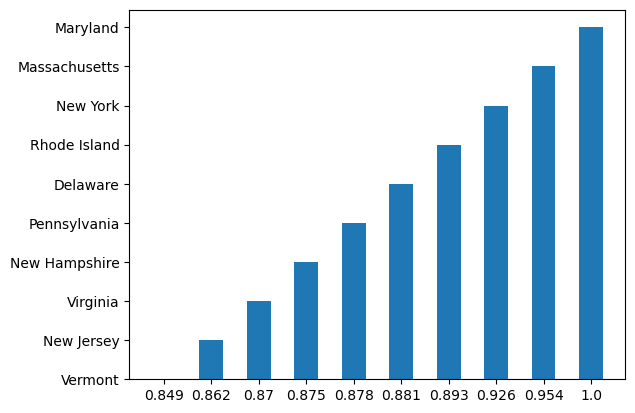

In [404]:
import matplotlib.pyplot as plt
plt.bar(range(len(result)), list(result.values()), tick_label=list(result.keys()), width=0.5)